# Band Excitation data procesing using pycroscopy
### Suhas Somnath, Chris R. Smith, Stephen Jesse
The Center for Nanophase Materials Science and The Institute for Functional Imaging for Materials <br>
Oak Ridge National Laboratory<br>
2/10/2017

## Configure the notebook

In [1]:
# !pip install -U numpy matplotlib Ipython ipywidgets pycroscopy

# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import

# Import necessary libraries:
# General utilities:
import sys
import os
import shutil

# Computation:
import numpy as np
import h5py

# Visualization:
# import ipympl
import matplotlib.pyplot as plt
import matplotlib.widgets as mpw
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets

# Finally, pycroscopy itself
sys.path.append('..')
import pycroscopy as px

# set up notebook to show plots within the notebook
% matplotlib notebook

# Make Notebook take up most of page width
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Set some basic parameters for computation
This notebook performs some functional fitting whose duration can be substantially decreased by using more memory and CPU cores. We have provided default values below but you may choose to change them if necessary.

In [2]:
max_mem         = 1024*8  # Maximum memory to use, in Mbs. Default = 1024
max_cores       = None    # Number of logical cores to use in fitting.  None uses all but 2 available cores.

## Make the data pycroscopy compatible
Converting the raw data into a pycroscopy compatible hierarchical data format (HDF or .h5) file gives you access to the fast fitting algorithms and powerful analysis functions within pycroscopy

#### H5 files:
* are like smart containers that can store matrices with data, folders to organize these datasets, images, metadata like experimental parameters, links or shortcuts to datasets, etc.
* are readily compatible with high-performance computing facilities
* scale very efficiently from few kilobytes to several terabytes
* can be read and modified using any language including Python, Matlab, C/C++, Java, Fortran, Igor Pro, etc.

#### You can load either of the following:
* Any .mat or .txt parameter file from the original experiment
* A .h5 file generated from the raw data using pycroscopy - skips translation

You can select desired file type by choosing the second option in the pull down menu on the bottom right of the file window

---- reading all data at once ----------
Computing Jobs In parallel ... launching 2 kernels...
---- Finished reading files -----


<IPython.core.display.Javascript object>


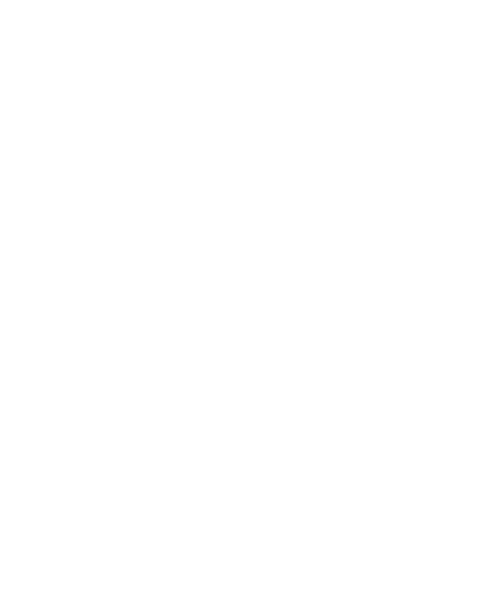

<IPython.core.display.Javascript object>


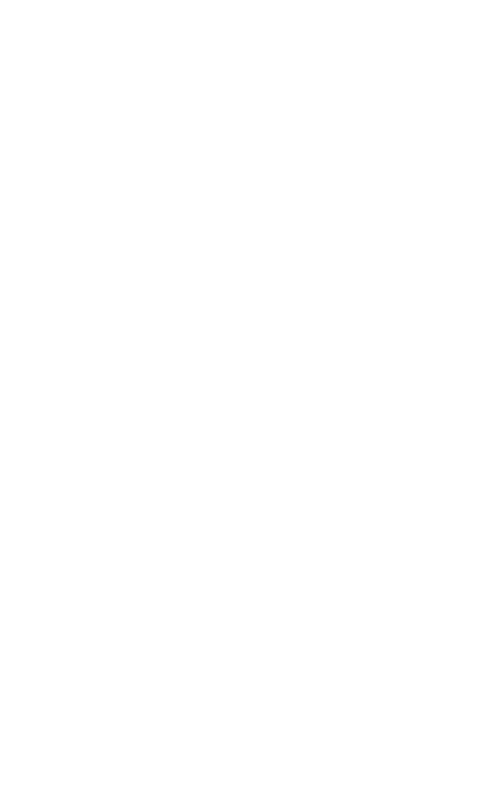

Completed generating spatially averaged plot groups
Working on:
/home/challtdow/workspace/pycroscopy_data/Raw_Data/BEPS/Old_Data_Format/Real_Data/Suhas/BEPS_8V_350kHz_40x40_0002/BEPS_8V_350kHz_40x40_0002.h5


In [3]:
# input_file_path = px.io_utils.uiGetFile(caption='Select translated .h5 file or raw experiment data',
#                                         file_filter='Parameters for raw BE data (*.txt *.mat *xls *.xlsx);; \
#                                         Translated file (*.h5)')

input_file_path = '/home/challtdow/workspace/pycroscopy_data/Raw_Data/BEPS/Old_Data_Format/Real_Data/Suhas/BEPS_8V_350kHz_40x40_0002/BEPS_8V_350kHz_40x40_parms_0002.txt'
# input_file_path = '/home/challtdow/workspace/pycroscopy_data/Raw_Data/BEPS/Old_Data_Format/Real_Data/Suhas/BEPS_8V_350kHz_40x40_0002/BEPS_8V_350kHz_40x40_0002.h5'

(data_dir, filename) = os.path.split(input_file_path)

if input_file_path.endswith('.h5'):
    # No translation here
    h5_path = input_file_path
    force = False # Set this to true to force patching of the datafile.
    tl = px.LabViewH5Patcher()
    hdf = tl.translate(h5_path, force_patch=force)
else:
    # Set the data to be translated
    data_path = input_file_path

    (junk, base_name) = os.path.split(data_dir)

    # Check if the data is in the new or old format.  Initialize the correct translator for the format.
    if base_name == 'newdataformat':
        (junk, base_name) = os.path.split(junk)
        translator = px.BEPSndfTranslator(max_mem_mb=max_mem)
    else:
        translator = px.BEodfTranslator(max_mem_mb=max_mem)
    if base_name.endswith('_d'):
        base_name = base_name[:-2]
    # Translate the data
    h5_path = translator.translate(data_path, show_plots=True, save_plots=False)
    hdf = px.ioHDF5(h5_path)
print('Working on:\n' + h5_path)

h5_main = px.hdf_utils.getDataSet(hdf.file, 'Raw_Data')[0]

##### Inspect the contents of this h5 data file
The file contents are stored in a tree structure, just like files on a conventional computer.
The data is stored as a 2D matrix (position, spectroscopic value) regardless of the dimensionality of the data. Thus, the positions will be arranged as row0-col0, row0-col1.... row0-colN, row1-col0.... and the data for each position is stored as it was chronologically collected  

The main dataset is always accompanied by four ancillary datasets that explain the position and spectroscopic value of any given element in the dataset.

In [4]:
print('Datasets and datagroups within the file:\n------------------------------------')
px.io.hdf_utils.print_tree(hdf.file)
 
print('\nThe main dataset:\n------------------------------------')
print(h5_main)
print('\nThe ancillary datasets:\n------------------------------------')
print(hdf.file['/Measurement_000/Channel_000/Position_Indices'])
print(hdf.file['/Measurement_000/Channel_000/Position_Values'])
print(hdf.file['/Measurement_000/Channel_000/Spectroscopic_Indices'])
print(hdf.file['/Measurement_000/Channel_000/Spectroscopic_Values'])

print('\nMetadata or attributes in a datagroup\n------------------------------------')
for key in hdf.file['/Measurement_000'].attrs:
    print('{} : {}'.format(key, hdf.file['/Measurement_000'].attrs[key]))

Datasets and datagroups within the file:
------------------------------------
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Bin_FFT
Measurement_000/Channel_000/Bin_Frequencies
Measurement_000/Channel_000/Bin_Indices
Measurement_000/Channel_000/Bin_Step
Measurement_000/Channel_000/Bin_Wfm_Type
Measurement_000/Channel_000/Excitation_Waveform
Measurement_000/Channel_000/Noise_Floor
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000/Bin_Frequencies
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000/Mean_Spectrogram
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000/Spectroscopic_Parameter
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000/Step_Averaged_Response
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_

## Get some basic parameters from the H5 file
This information will be vital for futher analysis and visualization of the data

In [5]:
h5_pos_inds = px.hdf_utils.getAuxData(h5_main, auxDataName='Position_Indices')[-1]
pos_sort = px.hdf_utils.get_sort_order(np.transpose(h5_pos_inds))
pos_dims = px.hdf_utils.get_dimensionality(np.transpose(h5_pos_inds), pos_sort)
pos_labels = np.array(px.hdf_utils.get_attr(h5_pos_inds, 'labels'))[pos_sort]
print(pos_labels, pos_dims)

parm_dict = hdf.file['/Measurement_000'].attrs
is_ckpfm = hdf.file.attrs['data_type'] == 'cKPFMData'
if is_ckpfm:
    num_write_steps = parm_dict['VS_num_DC_write_steps']
    num_read_steps = parm_dict['VS_num_read_steps']
    num_fields = 2

['X' 'Y'] [40, 40]


## Visualize the raw data
Use the sliders below to visualize spatial maps (2D only for now), and spectrograms.
For simplicity, all the spectroscopic dimensions such as frequency, excitation bias, cycle, field, etc. have been collapsed to a single slider.

No position datasets found as attributes of /Measurement_000/Channel_000/Spectroscopic_Values


<IPython.core.display.Javascript object>


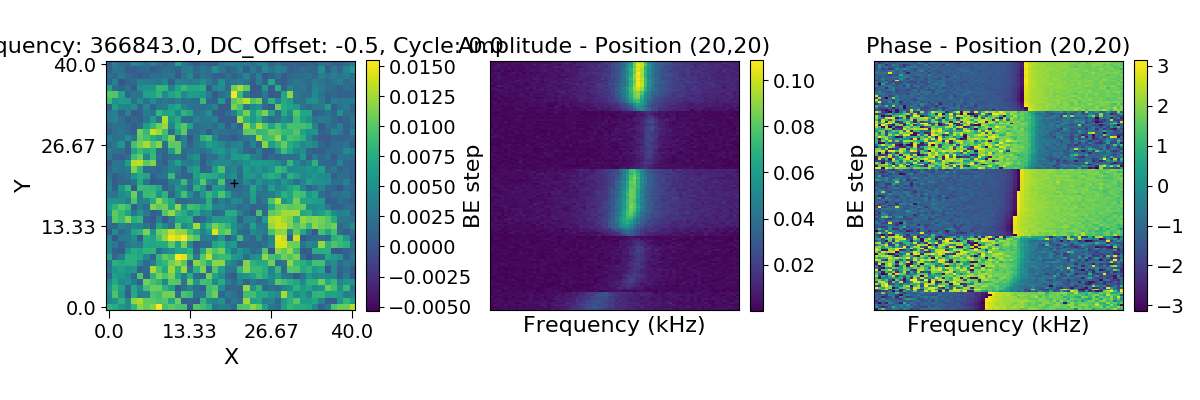

HBox(children=(Text(value='BEPS_8V_350kHz_40x40_0002.h5', description='Output Filename:', layout=Layout(width='50%'), placeholder='Type something'), Button(description='Save figure', style=ButtonStyle())))

interactive(children=(IntSlider(value=4479, description='step', max=8959), Output()), _dom_classes=('widget-interact',))

In [ ]:
px.be_viz_utils.jupyter_visualize_be_spectrograms(h5_main)

In [ ]:
sho_fit_points = 5 # The number of data points at each step to use when fitting

h5_sho_group = px.hdf_utils.findH5group(h5_main, 'SHO_Fit')
sho_fitter = px.BESHOmodel(h5_main, parallel=True)
if len(h5_sho_group) == 0:
    print('No SHO fit found. Doing SHO Fitting now')
    h5_sho_guess = sho_fitter.do_guess(strategy='complex_gaussian', processors=max_cores, max_mem=max_mem, options={'num_points':sho_fit_points})
    h5_sho_fit = sho_fitter.do_fit(processors=max_cores, max_mem=max_mem)
else:
    print('Taking previous SHO results already present in file')
    h5_sho_guess = h5_sho_group[-1]['Guess']
    try:
        h5_sho_fit = h5_sho_group[-1]['Fit']
    except KeyError:
        print('Previously computed guess found. Now computing fit')
        h5_sho_fit = sho_fitter.do_fit(processors=max_cores, max_mem=max_mem, h5_guess=h5_sho_guess)

No SHO fit found. Doing SHO Fitting now
Using complex_gaussian to find guesses...

Computing Jobs In parallel ... launching 2 kernels...


## Visualize the SHO results
Here, we visualize the parameters for the SHO fits. BE-line (3D) data is visualized via simple spatial maps of the SHO parameters while more complex BEPS datasets (4+ dimensions) can be visualized using a simple interactive visualizer below. 

You can choose to visualize the guesses for SHO function or the final fit values from the first line of the cell below.

Use the sliders below to inspect the BE response at any given location. 

In [ ]:
h5_sho_spec_inds = px.hdf_utils.getAuxData(h5_sho_fit, auxDataName='Spectroscopic_Indices')[0]
sho_spec_labels = px.io.hdf_utils.get_attr(h5_sho_spec_inds,'labels')

if is_ckpfm:
    # It turns out that the read voltage index starts from 1 instead of 0
    # Also the VDC indices are NOT repeating. They are just rising monotonically
    write_volt_index = np.argwhere(sho_spec_labels == 'write_bias')[0][0]
    read_volt_index = np.argwhere(sho_spec_labels == 'read_bias')[0][0]
    h5_sho_spec_inds[read_volt_index, :] -= 1
    h5_sho_spec_inds[write_volt_index, :] = np.tile(np.repeat(np.arange(num_write_steps), num_fields), num_read_steps)

(Nd_mat, success, nd_labels) = px.io.hdf_utils.reshape_to_Ndims(h5_sho_fit, get_labels=True)
print('Reshape Success: ' + str(success))

print(nd_labels)
print(Nd_mat.shape)

In [ ]:
use_sho_guess = False
use_static_viz_func = False

if use_sho_guess:
    sho_dset = h5_sho_guess
else:
    sho_dset = h5_sho_fit

data_type = px.io.hdf_utils.get_attr(hdf.file, 'data_type')
    
if data_type == 'BELineData' or len(pos_dims) != 2:
    use_static_viz_func = True
    step_chan = None
else:
    vs_mode = px.io.hdf_utils.get_attr(h5_main.parent.parent, 'VS_mode')
    if vs_mode not in ['AC modulation mode with time reversal', 
                                                      'DC modulation mode']:
        use_static_viz_func = True
    else:
        if vs_mode == 'DC modulation mode':
            step_chan = 'DC_Offset'
        else:
            step_chan = 'AC_Amplitude'
if not use_static_viz_func:
    try:
        # use interactive visualization
        px.be_viz_utils.jupyter_visualize_beps_sho(sho_dset, step_chan)
    except:
        raise
        print('There was a problem with the interactive visualizer')
        use_static_viz_func = True
else:
    # show plots of SHO results vs. applied bias
    px.be_viz_utils.visualize_sho_results(sho_dset, show_plots=True, 
                                          save_plots=False)

## Fit loops to a function
This is applicable only to DC voltage spectroscopy datasets from BEPS. The PFM hysteresis loops in this dataset will be projected to maximize the loop area and then fitted to a function.

Note: This computation generally takes a while for reasonably sized datasets.

In [ ]:
# Do the Loop Fitting on the SHO Fit dataset
loop_success = False
h5_loop_group = px.hdf_utils.findH5group(h5_sho_fit, 'Loop_Fit')
if len(h5_loop_group) == 0:
    try:
        loop_fitter = px.BELoopModel(h5_sho_fit, parallel=True)
        print('No loop fits found. Fitting now....')
        h5_loop_guess = loop_fitter.do_guess(processors=max_cores, max_mem=max_mem)
        h5_loop_fit = loop_fitter.do_fit(processors=max_cores, max_mem=max_mem)
        loop_success = True
    except ValueError:
        print('Loop fitting is applicable only to DC spectroscopy datasets!')
else:
    loop_success = True
    print('Taking previously computed loop fits')
    h5_loop_guess = h5_loop_group[-1]['Guess']
    h5_loop_fit = h5_loop_group[-1]['Fit']
h5_loop_group = h5_loop_fit.parent

## Prepare datasets for visualization

In [ ]:
# Prepare some variables for plotting loops fits and guesses
# Plot the Loop Guess and Fit Results
if loop_success:
    h5_projected_loops = h5_loop_guess.parent['Projected_Loops']
    h5_proj_spec_inds = px.hdf_utils.getAuxData(h5_projected_loops, 
                                                auxDataName='Spectroscopic_Indices')[-1]
    h5_proj_spec_vals = px.hdf_utils.getAuxData(h5_projected_loops, 
                                                auxDataName='Spectroscopic_Values')[-1]

    # reshape the vdc_vec into DC_step by Loop
    sort_order = px.hdf_utils.get_sort_order(h5_proj_spec_inds)
    dims = px.hdf_utils.get_dimensionality(h5_proj_spec_inds[()], 
                                           sort_order[::-1])
    vdc_vec = np.reshape(h5_proj_spec_vals[h5_proj_spec_vals.attrs['DC_Offset']], dims).T

    #Also reshape the projected loops to Positions-DC_Step-Loop
    # Also reshape the projected loops to Positions-DC_Step-Loop
    proj_nd, _ = px.hdf_utils.reshape_to_Ndims(h5_projected_loops)
    proj_3d = np.reshape(proj_nd, [h5_projected_loops.shape[0], 
                                   proj_nd.shape[2], -1])

## Visualize Loop fits

In [ ]:
use_static_plots = False
if loop_success:
    if not use_static_plots:
        try:
            px.be_viz_utils.jupyter_visualize_beps_loops(h5_projected_loops, h5_loop_guess, h5_loop_fit)
        except:
            print('There was a problem with the interactive visualizer')
            use_static_plots = True
    if use_static_plots:
        for iloop in range(h5_loop_guess.shape[1]):
            fig, ax = px.be_viz_utils.plot_loop_guess_fit(vdc_vec[:, iloop], proj_3d[:, :, iloop], 
                                          h5_loop_guess[:, iloop], h5_loop_fit[:, iloop],
                                          title='Loop {} - All Positions'.format(iloop))

## Loop Parameters
We will now load the loop parameters caluculated from the fit and plot them.

In [ ]:
h5_loop_parameters = h5_loop_group['Fit_Loop_Parameters']
px.viz.be_viz_utils.jupyter_visualize_parameter_maps(h5_loop_parameters)

In [ ]:
map_parm = 'Work of Switching'
plot_cycle = 0
plot_position = (int(pos_dims[0]/2), int(pos_dims[1]/2))
plot_bias_step = 0
px.viz.be_viz_utils.plot_loop_sho_raw_comparison(h5_loop_parameters, map_parm, plot_cycle, plot_position, plot_bias_step)


## Save and close
* Save the .h5 file that we are working on by closing it. <br>
* Also, consider exporting this notebook as a notebook or an html file. <br> To do this, go to File >> Download as >> HTML
* Finally consider saving this notebook if necessary

In [ ]:
# hdf.close()